In [1]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn_extra.cluster import CLARA
from sklearn. preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #29465B; color: white; padding: 10px; width: 100%;'>
    <h1> IMDb Movie Clustering </h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

### **Purpose**

This is a notebook that generates the mapping of movies to their cluster based on genre and decade. The output is a .csv file which will be used by the main notebook.

**Data Source**: [Kaggle](https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre)

*"Data is scraped from IMDb, the world's most popular and authoritative source for movie, TV, and celebrity content. IMDb has an extensive database of movies that is constantly updated with new titles and information.*

| Name         | Type | Description                      |
|--------------|------|----------------------------------|
| movie_id     | str  | IMDB Movie ID                    |
|**movie_name**| str  | Name of the movie                |
| **year**     | int  | Release year                     |
| certificate  | str  | Certificate of the movie         |
| run_time     | str  | Total movie run time             |
| **genre**    | str  | Genre of the movie               |
| rating       | float| Rating of the movie              |
| description  | str  | Description of the movie         |
| director     | str  | Director of the movie            |
| director_id  | str  | IMDB id of the director          |
| star         | str  | Star of the movie                |
| star_id      | str  | IMDB id of the star              |
| votes        | int  | Number of votes in IMDB website  |
| gross(in $)  | float| Gross Box Office of the movie ($)|


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>1.  Data Loading and Cleaning </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Movies prior to 1980 were excluded to limit scope.

In [2]:
df = pd.concat([pd.read_csv(ZipFile('imdb_movies.zip').open(i))
               for i in ZipFile('imdb_movies.zip').namelist()])
df = df[['movie_name', 'year', 'genre']]
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
df.dropna(subset = ['year'], inplace = True)
df.year = df.year.astype(int)
df = df[df['year'] >= 1980]

df.head(3)

,movie_name,year,genre
0,Black Panther: Wakanda Forever,2022,"Action, Adventure, Drama"
1,Avatar: The Way of Water,2022,"Action, Adventure, Fantasy"
2,Plane,2023,"Action, Thriller"


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>2.  Preprocessing </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [3]:
# creating genre columns
df[['genre_1', 'genre_2']] = (df['genre']
                              .str.split(', ')
                              .apply(lambda x: sorted(x)[:2] if isinstance(x, list) else x)
                              .apply(pd.Series)
                              )

df['decade'] = df['year'].apply(lambda x: str(x//10*10)+"'s")
df[['genre_1']] = df[['genre_1']].fillna(value='None')
df['genre_2'] = df['genre_2'].fillna(df['genre_1'])

df.sample(10, random_state=42)

,movie_name,year,genre,genre_1,genre_2,decade
3524,The Gracefield Incident,2017,"Action, Horror, Mystery",Action,Horror,2010's
4975,Pool Party Massacre,2017,"Comedy, Horror",Comedy,Horror,2010's
6161,The Toybox,2005,"Horror, Mystery, Thriller",Horror,Mystery,2000's
51381,Remain Humane,2018,Thriller,Thriller,Thriller,2010's
2868,The Bros,2017,"Comedy, Fantasy",Comedy,Fantasy,2010's
16112,Kalbimdeki Düsman,1987,"Adventure, Drama, Romance",Adventure,Drama,1980's
20035,Bleak Future,1997,"Action, Comedy, Horror",Action,Comedy,1990's
23199,Koti Sana,1999,"Action, Thriller",Action,Thriller,1990's
30444,A Lot Like Love,2018,Romance,Romance,Romance,2010's
31701,The Danger of Strangers,2021,Thriller,Thriller,Thriller,2020's


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>3.  Categorical Clustering using CLARA </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

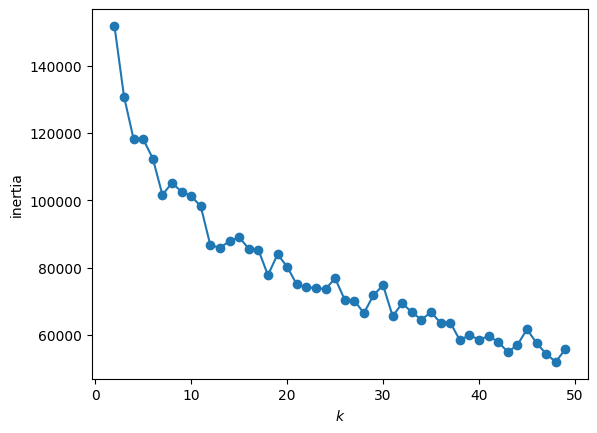

In [7]:
df_oe = OrdinalEncoder().fit_transform(df[['genre_1', 'genre_2', 'decade']])
x`
ks = list(range(2,50))
costs = [
    CLARA(k, metric="hamming", random_state=42)
    .fit(df_oe)
    .inertia_
    for k in ks
]

plt.plot(ks, costs, "-o")
plt.xlabel("$k$")
plt.ylabel("inertia");

In [38]:
clara_updated = CLARA(n_clusters = 50, metric = 'hamming', random_state = 42)
labels = clara_updated.fit_predict(df_oe)
df['cluster'] = labels

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>4. Save </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [39]:
df = df[['movie_name', 'year','genre_1', 'genre_2', 'decade', 'cluster']]
df.to_csv('df_movies_cat.csv', index=False)
df.sample(5)

,movie_name,year,genre_1,genre_2,decade,cluster
6517,The Legend of Fong Sai-Yuk 2,1993,Action,Adventure,1990's,0
15620,Shibaji,2008,Action,Drama,2000's,2
6525,The Wild Man: Skunk Ape,2021,Horror,Horror,2020's,29
7316,By Day and by Night,2010,Drama,Sci-Fi,2010's,3
342,Speed Zone,1989,Action,Comedy,1980's,8


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>5. Inspect </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [40]:
for i in set(df.cluster):
    display(df.loc[df.cluster==i].sample(5, random_state=42))

,movie_name,year,genre_1,genre_2,decade,cluster
711,Batman: Mask of the Phantasm,1993,Action,Adventure,1990's,0
23068,The Devil's Interval,2011,Action,Adventure,2010's,0
645,Papillon,2017,Adventure,Biography,2010's,0
1353,Queen of the Desert,2015,Adventure,Biography,2010's,0
30016,Un affare trasversale,1998,Action,Adventure,1990's,0


,movie_name,year,genre_1,genre_2,decade,cluster
49312,Afro Samurai Live Action Hood Ninja,2021,Action,Action,2020's,1
22875,Cielo senza terra (Edit 2020),2021,Adventure,Adventure,2020's,1
4561,The Pope Drops In,2023,Family,Family,2020's,1
3766,The Rebels of PT-218,2021,Action,Adventure,2020's,1
15093,When Dance Meets Music Stage Play Concert & Pr...,2021,Family,Family,2020's,1


,movie_name,year,genre_1,genre_2,decade,cluster
3134,Zuzu Angel,2006,Biography,Drama,2000's,2
5770,Pithamagan,2003,Action,Drama,2000's,2
8056,The Mighty Eels Volume One 1908-1966,2004,History,History,2000's,2
7905,Twisted Sisters,2006,Crime,Thriller,2000's,2
19379,Ten Monologues from the Lives of the Serial Ki...,1994,Crime,Drama,1990's,2


,movie_name,year,genre_1,genre_2,decade,cluster
4908,Savage Hunt of King Stakh,1980,Drama,Horror,1980's,3
7775,The Soup,2017,Drama,Family,2010's,3
8517,Love,1991,Drama,Musical,1990's,3
13601,Objects in Mirror,2013,Drama,Family,2010's,3
3347,Kamilla og tyven,1988,Drama,Family,1980's,3


,movie_name,year,genre_1,genre_2,decade,cluster
48345,Lumuhod ka sa lupa,1993,Action,Drama,1990's,4
1587,Goya in Bordeaux,1999,Biography,Drama,1990's,4
34441,Pyasa Yauvan,1993,Thriller,Thriller,1990's,4
8993,Another Meltdown,1998,Action,Thriller,1990's,4
8659,The Children of Captain Grant,1996,Adventure,Drama,1990's,4


,movie_name,year,genre_1,genre_2,decade,cluster
5943,Nun,2017,Horror,Mystery,2010's,5
15010,Inkblot,2017,Horror,Mystery,2010's,5
3197,The Shrine,2010,Horror,Horror,2010's,5
889,A Nightmare on Elm Street 2: Freddy's Revenge,1985,Horror,Horror,1980's,5
11098,Angry Nazi Zombies,2012,Horror,War,2010's,5


,movie_name,year,genre_1,genre_2,decade,cluster
30003,Show,2003,Action,Comedy,2000's,6
1627,The One,2001,Action,Sci-Fi,2000's,6
21422,Auf Herz und Nieren,2001,Action,Comedy,2000's,6
6271,The Hero: Love Story of a Spy,2003,Action,Adventure,2000's,6
1226,The Forbidden Kingdom,2008,Action,Adventure,2000's,6


,movie_name,year,genre_1,genre_2,decade,cluster
2259,American Warfighter,2018,Action,Drama,2010's,7
6450,The Giants,2011,Adventure,Drama,2010's,7
23060,Tragedy of a Mother and Son,2012,Action,Drama,2010's,7
36350,Deadly Consequences,2010,Action,Drama,2010's,7
35919,MountAlien,2018,Action,Drama,2010's,7


,movie_name,year,genre_1,genre_2,decade,cluster
31006,La fuga del chacal,1987,Action,Thriller,1980's,8
7825,Fighting Back,1982,Action,Crime,1980's,8
14842,Out on Bail,1989,Action,Crime,1980's,8
18943,Joaquin Bordado,1988,Action,Fantasy,1980's,8
7298,Image of the Beast,1981,Sci-Fi,Thriller,1980's,8


,movie_name,year,genre_1,genre_2,decade,cluster
20252,Anaganaga O Athidhi,2020,Drama,Thriller,2020's,9
31362,Blood Sugar,2020,Thriller,Thriller,2020's,9
29714,A Cisterna,2021,Thriller,Thriller,2020's,9
2213,The Evil Next Door,2020,Horror,Mystery,2020's,9
10649,Nite Tales: The Movie,2008,Horror,Thriller,2000's,9


,movie_name,year,genre_1,genre_2,decade,cluster
14427,Vengeance,2013,Crime,Drama,2010's,10
29902,Día de Furia,2013,Crime,Crime,2010's,10
5405,Awakening the Zodiac,2017,Crime,Drama,2010's,10
10965,Lakeer Ka Fakeer,2013,Crime,Crime,2010's,10
17581,Ridge Runners,2018,Crime,Drama,2010's,10


,movie_name,year,genre_1,genre_2,decade,cluster
36710,Supplementary,2019,Romance,Romance,2010's,11
4022,Our Family Wedding,2010,Comedy,Romance,2010's,11
17163,Two Weddings and a Funeral,2012,Comedy,Romance,2010's,11
45445,...I vsya lyubov,1989,Drama,Romance,1980's,11
12673,Tej... I Love You,2018,Romance,Romance,2010's,11


,movie_name,year,genre_1,genre_2,decade,cluster
6904,Bar Starz,2008,Adventure,Comedy,2000's,12
8022,Rebirth of Mothra III,1998,Adventure,Fantasy,1990's,12
10785,Golnar,1989,Adventure,Comedy,1980's,12
6610,Yamato Takeru,1994,Adventure,Fantasy,1990's,12
19178,Something to Sleep On,2009,Adventure,Comedy,2000's,12


,movie_name,year,genre_1,genre_2,decade,cluster
19158,Kizhakke Varum Paattu,1993,Romance,Romance,1990's,13
40168,Mahisagarne Aare,1989,Romance,Romance,1980's,13
29267,Dui Jibon,1987,Romance,Romance,1980's,13
44644,Zavtra,1991,Romance,Romance,1990's,13
24229,True Love,1992,Romance,Romance,1990's,13


,movie_name,year,genre_1,genre_2,decade,cluster
2876,"Tsatsiki, Mum and the Policeman",1999,Drama,Family,1990's,14
11517,Piet Piraat Show: De Toverlantaarn,2019,Comedy,Family,2010's,14
5279,Super Xuxa Contra o Baixo Astral,1988,Comedy,Family,1980's,14
13583,Cert ví proc,2003,Comedy,Family,2000's,14
6770,Kaczorek Felus,1990,Animation,Family,1990's,14


,movie_name,year,genre_1,genre_2,decade,cluster
5492,"Crazy, Stupid, Love",2022,Comedy,Drama,2020's,15
13411,Las noches que mirábamos al cielo,2019,Comedy,Sci-Fi,2010's,15
14189,The Great Traveller,2021,Comedy,Drama,2020's,15
331,Love Again,2023,Comedy,Drama,2020's,15
9933,Jodi,2023,Comedy,Drama,2020's,15


,movie_name,year,genre_1,genre_2,decade,cluster
10321,Urutoraman sutori,1984,Sci-Fi,Sci-Fi,1980's,16
3471,Time Chasers,1994,Sci-Fi,Sci-Fi,1990's,16
1992,The Door Into Summer,2021,Sci-Fi,Sci-Fi,2020's,16
9119,"Chengdu, wo ai ni",2009,Sci-Fi,Sci-Fi,2000's,16
4918,Greatland,2020,Fantasy,Sci-Fi,2020's,16


,movie_name,year,genre_1,genre_2,decade,cluster
42433,El fin de los Arellano,2003,Action,Action,2000's,17
15965,Naaga,2003,Action,Action,2000's,17
31503,Hurricane Bullet,2003,Action,Action,2000's,17
18863,Kukkhato Khuni,2000,Action,Action,2000's,17
13566,The Operative,2000,Action,Action,2000's,17


,movie_name,year,genre_1,genre_2,decade,cluster
13052,LokalFilmis,2015,Animation,Comedy,2010's,18
15366,Sbank,2013,Action,Comedy,2010's,18
3208,Kill Me Three Times,2014,Action,Comedy,2010's,18
739,The Art of Self-Defense,2019,Action,Comedy,2010's,18
14360,The Gertrude Stein Mystery or Some Like It Art,2010,Biography,Comedy,2010's,18


,movie_name,year,genre_1,genre_2,decade,cluster
4807,Winter in Peru: A Visual Ode to the Waves of Peru,2008,Sport,Sport,2000's,19
4189,PinPin Three Return of the Stedi,2003,Sport,Sport,2000's,19
4699,Madrid Derby,2020,Sport,Sport,2020's,19
3783,1987 Best of Memphis TV Yearbook Volume 1,2016,Sport,Sport,2010's,19
3748,Norwich City vs Liverpool,2012,Sport,Sport,2010's,19


,movie_name,year,genre_1,genre_2,decade,cluster
34013,Show Time,2016,Thriller,Thriller,2010's,20
32789,Lindängens Park,2016,Thriller,Thriller,2010's,20
27650,Rabbit Woman,2013,Thriller,Thriller,2010's,20
35707,A Girl Named Grace,2012,Horror,Thriller,2010's,20
33296,Silenced,2018,Horror,Thriller,2010's,20


,movie_name,year,genre_1,genre_2,decade,cluster
4901,Syupeo Samchongsa,1982,Animation,Animation,1980's,21
927,The Creepy Witch,2023,Animation,Animation,2020's,21
2925,The Land Between the Lakes,2021,Animation,Animation,2020's,21
2088,Stand by Me Doraemon 2,2020,Animation,Comedy,2020's,21
5328,Mission H2O,2018,Animation,Animation,2010's,21


,movie_name,year,genre_1,genre_2,decade,cluster
9578,Broken,2014,Action,Crime,2010's,22
18635,Bairro,2013,Action,Crime,2010's,22
4870,A Perfect Family,2017,Biography,Crime,2010's,22
13084,S Storm,2016,Action,Crime,2010's,22
1910,Dog Eat Dog,2016,Action,Crime,2010's,22


,movie_name,year,genre_1,genre_2,decade,cluster
25544,Telling Lies,2008,Thriller,Thriller,2000's,23
47210,Flashmob,2008,Drama,Thriller,2000's,23
35224,Magma,2009,Thriller,Thriller,2000's,23
32506,Flooding,2000,Drama,Thriller,2000's,23
52118,Jawan Kanya,2005,Thriller,Thriller,2000's,23


,movie_name,year,genre_1,genre_2,decade,cluster
2591,And the Violins Stopped Playing,1988,Biography,Drama,1980's,24
306,Stand and Deliver,1988,Biography,Drama,1980's,24
3955,"JO, The van Goghs' Widow",2023,Biography,Drama,2020's,24
5,Oppenheimer,2023,Biography,Drama,2020's,24
232,Resistance,2020,Biography,Drama,2020's,24


,movie_name,year,genre_1,genre_2,decade,cluster
13856,Flight from Hell,2014,Action,Horror,2010's,25
8584,Dead Cert,2010,Action,Horror,2010's,25
7199,Dead Cert,2010,Action,Horror,2010's,25
4255,Tank 432,2015,Action,Horror,2010's,25
33999,Chiroptera,2019,Action,Horror,2010's,25


,movie_name,year,genre_1,genre_2,decade,cluster
3390,My True Fairytale,2021,Drama,Mystery,2020's,26
5808,Ward 126,2022,Drama,Mystery,2020's,26
11222,B.E.D.,2012,Drama,Mystery,2010's,26
4335,C U Soon,2020,Drama,Mystery,2020's,26
12485,The Clean Bones Gone,2017,Drama,Mystery,2010's,26


,movie_name,year,genre_1,genre_2,decade,cluster
3121,Ted Bundy,2002,Biography,Crime,2000's,27
7043,Brâncusi,1996,Biography,Biography,1990's,27
4189,Ho conosciuto Magnus,2016,Biography,Biography,2010's,27
6978,They knew him only by sight,2004,Biography,Biography,2000's,27
7027,Dignity and Defiance: A Portrait of Mary Churc...,2017,Biography,Biography,2010's,27


,movie_name,year,genre_1,genre_2,decade,cluster
1111,Nobody Sleeps in the Woods Tonight,2020,Fantasy,Horror,2020's,28
20333,The Land of the Untouched Doors,2021,Adventure,Fantasy,2020's,28
25096,Johan,2021,Fantasy,Horror,2020's,28
13007,Astray Lamb,1993,Fantasy,Fantasy,1990's,28
15033,Settecento,2002,Fantasy,Fantasy,2000's,28


,movie_name,year,genre_1,genre_2,decade,cluster
25956,Children of the Sun,2020,Horror,Horror,2020's,29
26734,Weird Day,2022,Horror,Horror,2020's,29
10487,The Haunting,2020,Horror,Horror,2020's,29
13912,Vibration,2020,Horror,Horror,2020's,29
45542,Branches,2020,Comedy,Horror,2020's,29


,movie_name,year,genre_1,genre_2,decade,cluster
33246,Door Gods,2020,Action,Comedy,2020's,30
2960,The Hyperions,2022,Action,Comedy,2020's,30
5004,Equally Friends,2022,Biography,Comedy,2020's,30
2996,The Paper Tigers,2020,Action,Comedy,2020's,30
29634,Lovers,2020,Action,Comedy,2020's,30


,movie_name,year,genre_1,genre_2,decade,cluster
2723,In China They Eat Dogs,1999,Action,Comedy,1990's,31
31405,Captive Commandos,1990,Action,Comedy,1990's,31
25454,Miss na miss kita (Utol kong hoodlum II),1992,Action,Comedy,1990's,31
5868,Kunoichi ninpô-chô II: Sei-shôjo no hihô,1992,Action,Comedy,1990's,31
3090,Circuitry Man,1990,Action,Comedy,1990's,31


,movie_name,year,genre_1,genre_2,decade,cluster
30067,Munjaneya Manju,1993,Crime,Thriller,1990's,32
16321,Lady Killer,1995,Horror,Mystery,1990's,32
12737,OL renzoku rape: Kyonyû musaboru,1990,Crime,Crime,1990's,32
10359,Call Me Mr. Brown,1990,Crime,Crime,1990's,32
26026,Molested,1992,Crime,Crime,1990's,32


,movie_name,year,genre_1,genre_2,decade,cluster
6445,Tsena vozvrata,1983,Adventure,War,1980's,33
25196,Cetatea ascunsa,1987,Adventure,Adventure,1980's,33
6539,Missing Link,1988,Adventure,Adventure,1980's,33
10541,Con el cuerpo prestado,1983,Comedy,Fantasy,1980's,33
4429,Jaadugar,1989,Comedy,Fantasy,1980's,33


,movie_name,year,genre_1,genre_2,decade,cluster
3883,Bullshot Crummond,1983,Action,Adventure,1980's,34
996,Condorman,1981,Action,Adventure,1980's,34
1712,Yor: The Hunter from the Future,1983,Action,Adventure,1980's,34
10906,Shaolin Hellgate,1980,Action,Adventure,1980's,34
12523,Thunder III,1988,Action,Adventure,1980's,34


,movie_name,year,genre_1,genre_2,decade,cluster
34949,Amin: Amen,2020,Action,Drama,2020's,35
13651,The Place We're Going,2022,Adventure,Drama,2020's,35
2294,Remember,2022,Action,Drama,2020's,35
34413,Herobrine Origins Part IV,2020,Action,Drama,2020's,35
5625,Rev,2020,Action,Drama,2020's,35


,movie_name,year,genre_1,genre_2,decade,cluster
23901,8 Man,1992,Action,Sci-Fi,1990's,36
10130,The Future Hero,1997,Action,Sci-Fi,1990's,36
6999,The Gifted,1993,Fantasy,Sci-Fi,1990's,36
13193,The Shadow Men,1997,Action,Sci-Fi,1990's,36
5435,Project Shadowchaser II,1994,Action,Sci-Fi,1990's,36


,movie_name,year,genre_1,genre_2,decade,cluster
20062,Aferzysci. Zle psy,2022,Action,Crime,2020's,37
2247,Happily,2021,Comedy,Crime,2020's,37
9214,Peace Makers,2021,Action,Crime,2020's,37
5313,Friendship,2021,Action,Crime,2020's,37
6468,Natasha Nighty's Boudoir of Blood,2020,Comedy,Crime,2020's,37


,movie_name,year,genre_1,genre_2,decade,cluster
5336,Into the Void,2019,Adventure,Sci-Fi,2010's,38
10834,Deus Ex Baryon,2019,Animation,Sci-Fi,2010's,38
24121,Naani,2016,Horror,Sci-Fi,2010's,38
11751,Altered Species,2001,Horror,Sci-Fi,2000's,38
22129,RWD,2015,Horror,Sci-Fi,2010's,38


,movie_name,year,genre_1,genre_2,decade,cluster
4579,Sol Alegria,2018,Comedy,Fantasy,2010's,39
4203,The Little Ghost,2013,Family,Fantasy,2010's,39
18900,Ximbi Xombix,2019,Comedy,Fantasy,2010's,39
2708,Bhooter Bhabishyat,2012,Comedy,Fantasy,2010's,39
3012,Symbol,2009,Comedy,Fantasy,2000's,39


,movie_name,year,genre_1,genre_2,decade,cluster
8547,The Strange Ones,2017,Drama,Thriller,2010's,40
38313,Violent Love,2017,Drama,Thriller,2010's,40
34699,A to Zen,1997,Drama,Thriller,1990's,40
10417,Madtown,2016,Drama,Thriller,2010's,40
42654,Memorias de Alicia,2011,Drama,Thriller,2010's,40


,movie_name,year,genre_1,genre_2,decade,cluster
24004,"Boobs, Bunz & Bawdiness Vol 2",2017,Comedy,Horror,2010's,41
26761,La dernière incarnation,2005,Comedy,Horror,2000's,41
10120,Fangs,2002,Comedy,Horror,2000's,41
10613,Geethanjali,2014,Comedy,Horror,2010's,41
4249,"Exorcism at 60,000 Feet",2019,Comedy,Horror,2010's,41


,movie_name,year,genre_1,genre_2,decade,cluster
29520,Bazarer Coolie,2012,Action,Action,2010's,42
46825,CD Leganés vs Celta de Vigo,2018,Action,Action,2010's,42
35073,Game by Game,2015,Action,Action,2010's,42
29076,Opposite Blood,2012,Action,Action,2010's,42
51913,The D,2010,Action,Action,2010's,42


,movie_name,year,genre_1,genre_2,decade,cluster
10183,Hathyar: Face to Face with Reality,2002,Action,Crime,2000's,43
232,Fast & Furious,2009,Action,Crime,2000's,43
32960,Nam Naadu,2007,Action,Crime,2000's,43
9261,Foul Gesture,2006,Comedy,Crime,2000's,43
866,Hannibal Rising,2007,Adventure,Crime,2000's,43


,movie_name,year,genre_1,genre_2,decade,cluster
6420,Still Living in God's Universe,2013,Action,Animation,2010's,44
452,Ice Age: Continental Drift,2012,Adventure,Animation,2010's,44
18555,Kuiba: the Dragon Spirit Iii,2014,Adventure,Animation,2010's,44
484,Rio 2,2014,Adventure,Animation,2010's,44
3542,A Letter to Momo,2011,Adventure,Animation,2010's,44


,movie_name,year,genre_1,genre_2,decade,cluster
443,The Emigrants,2021,Drama,History,2020's,45
21909,Vignette,2022,Drama,Romance,2020's,45
4621,Santa Bootcamp,2022,Comedy,Romance,2020's,45
9225,Mr. Deshee,2021,Drama,Family,2020's,45
106,Are You,2023,Comedy,Romance,2020's,45


,movie_name,year,genre_1,genre_2,decade,cluster
16372,"Vornoff, Behind the Locked Door",2012,Sci-Fi,Sci-Fi,2010's,46
8113,Beethopia,2011,Sci-Fi,Sci-Fi,2010's,46
4923,Index Zero,2014,Sci-Fi,Sci-Fi,2010's,46
15960,Letter to a Young Planet,2018,Sci-Fi,Sci-Fi,2010's,46
15591,Star Wars: The Dark Reckoning,2017,Sci-Fi,Sci-Fi,2010's,46


,movie_name,year,genre_1,genre_2,decade,cluster
1689,Hometown Legend,2002,Drama,Family,2000's,47
11129,My Love Yurie,2008,Drama,Fantasy,2000's,47
8430,Devadoothan,2000,Drama,Horror,2000's,47
31567,Chui-si zao-wu ai-ge,2005,Fantasy,Horror,2000's,47
8428,Tere Liye,2001,Drama,Family,2000's,47


,movie_name,year,genre_1,genre_2,decade,cluster
12233,Plurality,2021,Action,Sci-Fi,2020's,48
16612,Extraction Point,2021,Action,Sci-Fi,2020's,48
1830,Invasion,2020,Action,Sci-Fi,2020's,48
16539,The World in 2080,2023,Action,Sci-Fi,2020's,48
2457,Occupation: Rainfall,2020,Action,Sci-Fi,2020's,48


,movie_name,year,genre_1,genre_2,decade,cluster
13772,Casanova Variations,2014,Biography,Drama,2010's,49
368,Mandela: Long Walk to Freedom,2013,Biography,Drama,2010's,49
4389,Trinta,2014,Biography,Drama,2010's,49
4908,Burning Blue,2013,Biography,Drama,2010's,49
3463,Mahalaya,2019,Biography,Drama,2010's,49
